# [Polynomial Expansion for Orientation and Motion Estimation](http://www.diva-portal.org/smash/get/diva2:302485/FULLTEXT01.pdf)

Gunnar Farnebäck

## 7. Displacement Estimation

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from PIL import Image
import scipy

**Signal**

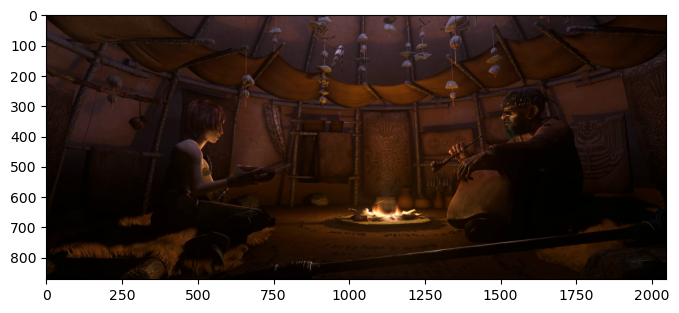

In [2]:
im1 = Image.open('sintel210_1.png')
im2 = Image.open('sintel210_2.png')

fig, ax = plt.subplots()
fig.set_figwidth(8)
ax.imshow(im1)
plt.show()

**Function to show displacement**

In [3]:
def showdisp(d):
    fig, (ax_displacement, ax_orientation) = plt.subplots(1, 2, width_ratios=[7, 1])
    fig.set_figwidth(8)

    angles = np.arctan2(d[..., 1], d[..., 0])
    angles = (angles + np.pi) / (2 * np.pi)
    lengths = np.hypot(d[..., 0], d[..., 1])
    hsv = np.ones(angles.shape + (3,))
    hsv[..., 0] = angles
    hsv[..., 2] = lengths * 0.25
    colors = matplotlib.colors.hsv_to_rgb(hsv.clip(0, 1))
    ax_displacement.imshow(colors, interpolation='none')

    x = np.linspace(-1, 1, 256)
    xx, yy = np.meshgrid(x, x)
    orientations = (np.arctan2(yy, xx) + np.pi) / (2 * np.pi)
    lengths = np.hypot(xx, yy)
    hsv = np.zeros(orientations.shape + (3,))
    hsv[..., 0] = orientations
    hsv[..., 1] = lengths < 1
    hsv[..., 2] = lengths * 1.5
    colors = matplotlib.colors.hsv_to_rgb(hsv.clip(0, 1))
    ax_orientation.imshow(colors, interpolation='none')
    ax_orientation.axis('off')

    plt.show()

**Polynomial expansion of 2 frames**

In [4]:
def polyexp(signal, spatial_size, sigma):
  n = (spatial_size - 1) / 2
  x = np.arange(-n, n + 1)
  a = np.exp(-0.5 * x ** 2 / sigma ** 2)

  ones = np.ones(a.size, dtype=int)

  B_x = np.stack([ones, x,    ones, x ** 2, ones,   x])
  B_y = np.stack([ones, ones, x,    ones,   x ** 2, x])
  B = np.einsum('ki,kj->ijk', B_x, B_y).reshape(a.size ** 2, B_x.shape[0])

  G = np.dot(np.outer(a, a).reshape(-1) * B.T, B)
  invG = np.linalg.inv(G)

  BWa_1D_one = a
  BWa_1D_x = a * x
  BWa_1D_x2 = a * x ** 2

  BWaf_1D_one = scipy.ndimage.correlate1d(signal, BWa_1D_one, axis=1, mode='constant')
  BWaf_1D_x = scipy.ndimage.correlate1d(signal, BWa_1D_x, axis=1, mode='constant')
  BWaf_1D_x2 = scipy.ndimage.correlate1d(signal, BWa_1D_x2, axis=1, mode='constant')

  BWaf_one = scipy.ndimage.correlate1d(BWaf_1D_one, BWa_1D_one.T, axis=0, mode='constant')
  BWaf_x = scipy.ndimage.correlate1d(BWaf_1D_x, BWa_1D_one.T, axis=0, mode='constant')
  BWaf_y = scipy.ndimage.correlate1d(BWaf_1D_one, BWa_1D_x.T, axis=0, mode='constant')
  BWaf_x2 = scipy.ndimage.correlate1d(BWaf_1D_x2, BWa_1D_one.T, axis=0, mode='constant')
  BWaf_y2 = scipy.ndimage.correlate1d(BWaf_1D_one, BWa_1D_x2.T, axis=0, mode='constant')
  BWaf_xy = scipy.ndimage.correlate1d(BWaf_1D_x, BWa_1D_x.T, axis=0, mode='constant')

  BWaf = np.stack([BWaf_one, BWaf_x, BWaf_y, BWaf_x2, BWaf_y2, BWaf_xy])

  r = np.einsum('li,ijk', invG, BWaf)

  return r

In [5]:
spatial_size = 11
sigma = 1.5

f1 = np.array(im1.convert('L'), dtype=float)
f2 = np.array(im2.convert('L'), dtype=float)

r1 = polyexp(f1, spatial_size, sigma)
r2 = polyexp(f2, spatial_size, sigma)

**Convertion to local signal model**

In [6]:
c1 = r1[..., 0]
b1 = r1[..., 1:3]
A1 = r1[..., [[3, 5], [5, 4]]] / np.array([[1, 2], [2, 1]])

c2 = r2[..., 0]
b2 = r2[..., 1:3]
A2 = r2[..., [[3, 5], [5, 4]]] / np.array([[1, 2], [2, 1]])

**Pointwise solution (noisy)**

In [7]:
A = (A1 + A2) / 2
delta_b = -(1 / 2) * (b2 - b1)

AT = A.swapaxes(-1, -2)
ATA = AT @ A
ATb = AT @ delta_b[..., np.newaxis]

In [8]:
d = (np.linalg.pinv(ATA) @ ATb)[..., 0]

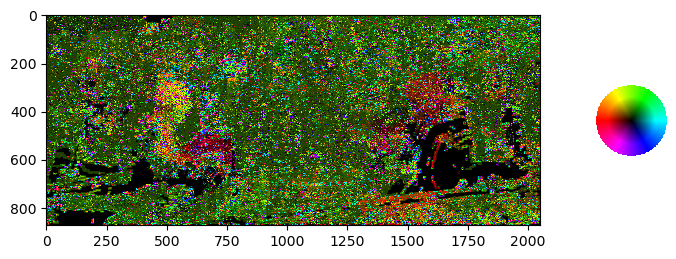

In [9]:
showdisp(d)

**Estimation over a neighborhood**

In [10]:
spatial_size = 11
sigma = 1.5

n = (spatial_size - 1) / 2
x = np.arange(-n, n + 1)
w = np.exp(-0.5 * x ** 2 / sigma ** 2)

ATA_avg = scipy.ndimage.correlate1d(ATA, w, axis=0, mode='constant')
ATA_avg = scipy.ndimage.correlate1d(ATA_avg, w, axis=1, mode='constant')

ATb_avg = scipy.ndimage.correlate1d(ATb, w, axis=0, mode='constant')
ATb_avg = scipy.ndimage.correlate1d(ATb_avg, w, axis=1, mode='constant')

In [11]:
d = np.linalg.solve(ATA_avg, ATb_avg)[..., 0]

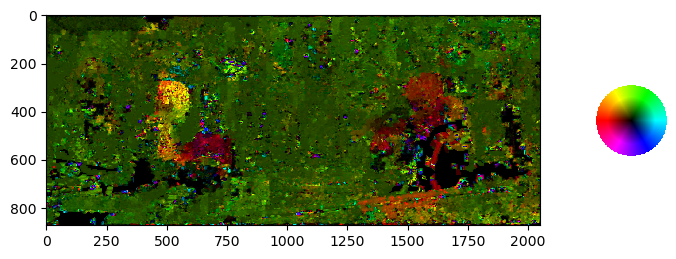

In [12]:
showdisp(d)